# Predict Future Sales

## About the competition

For the competition:- 

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

## Data Description 


You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Checkout the data set at [Kaggle](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data)

Training data set contains almost 5 million rows and test have 2 million rows . To work on that big data require have good computational power. 
For for this competiton i am using Google Colab Notebook as with it google provide free gpu service.

### Import data from kaggle to google colab directly using Kaggle API.

- How the kaggle api works : [Kaggle api](https://www.kaggle.com/general/51425)

- Generate your kaggle api Credentials: [kaggle Credentials](https://github.com/Kaggle/kaggle-api)

In [2]:
# Upload your kaggle credentials.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vin1234","key":"6e16eb14389b45601d78194fa5cbd8db"}'}

In [0]:
# to work with kaggle you need to create a kaggle directory and copy your kaggle credential to kaggle directory.
! mkdir -p ~/.kaggle
# copy your kaggle credential to kaggle directory.
! cp kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json



In [4]:
! kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 6.68MB/s]
  0% 0.00/1.50M [00:00<?, ?B/s]
100% 1.50M/1.50M [00:00<00:00, 100MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 2.74MB/s]
  0% 0.00/469k [00:00<?, ?B/s]
100% 469k/469k [00:00<00:00, 153MB/s]
  0% 0.00/1.01M [00:00<?, ?B/s]
100% 1.01M/1.01M [00:00<00:00, 137MB/s]
 39% 5.00M/12.9M [00:00<00:00, 33.2MB/s]
100% 12.9M/12.9M [00:00<00:00, 51.1MB/s]


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import ensemble, metrics

In [6]:
parser = lambda date: pd.to_datetime(date, format='%d.%m.%Y')

train = pd.read_csv('sales_train.csv.gz', parse_dates=['date'], date_parser=parser)
test = pd.read_csv('test.csv.gz')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
print('train:', train.shape, 'test:', test.shape, 'items:', items.shape, 'item_cats:', item_cats.shape, 'shops:', shops.shape)

train: (2935849, 6) test: (214200, 3) items: (22170, 3) item_cats: (84, 2) shops: (60, 2)


In [7]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [8]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [9]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [10]:
item_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [11]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


##  Data analysis

In [12]:
print(train['date_block_num'].max())

33


In [13]:
print(train['item_cnt_day'].describe())

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64


In [14]:
test_only = test[~test['item_id'].isin(train['item_id'].unique())]['item_id'].unique()
print('test only items:', len(test_only))

test only items: 363


## Preprocessing

In [15]:
# drop duplicates
subset = ['date','date_block_num','shop_id','item_id','item_cnt_day']
print(train.duplicated(subset=subset).value_counts())
train.drop_duplicates(subset=subset, inplace=True)

False    2935825
True          24
dtype: int64


In [16]:
# drop shops&items not in test data
test_shops = test.shop_id.unique()
test_items = test.item_id.unique()
train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

print('train:', train.shape)

train: (1224429, 6)


In [17]:
from itertools import product

# create all combinations
block_shop_combi = pd.DataFrame(list(product(np.arange(34), test_shops)), columns=['date_block_num','shop_id'])
shop_item_combi = pd.DataFrame(list(product(test_shops, test_items)), columns=['shop_id','item_id'])
all_combi = pd.merge(block_shop_combi, shop_item_combi, on=['shop_id'], how='inner')
print(len(all_combi), 34 * len(test_shops) * len(test_items))

# group by monthly
train_base = pd.merge(all_combi, train, on=['date_block_num','shop_id','item_id'], how='left')
train_base['item_cnt_day'].fillna(0, inplace=True)
train_grp = train_base.groupby(['date_block_num','shop_id','item_id'])

7282800 7282800


##  Aggregate

In [18]:
# summary count by month
train_monthly = pd.DataFrame(train_grp.agg({'item_cnt_day':['sum','count']})).reset_index()
train_monthly.columns = ['date_block_num','shop_id','item_id','item_cnt','item_order']
print(train_monthly[['item_cnt','item_order']].describe())
# trim count
train_monthly['item_cnt'].clip(0, 20, inplace=True)

train_monthly.head()

           item_cnt    item_order
count  7.282800e+06  7.282800e+06
mean   2.221345e-01  1.085718e+00
std    3.324564e+00  7.254517e-01
min   -4.000000e+00  1.000000e+00
25%    0.000000e+00  1.000000e+00
50%    0.000000e+00  1.000000e+00
75%    0.000000e+00  1.000000e+00
max    2.253000e+03  3.100000e+01


,date_block_num,shop_id,item_id,item_cnt,item_order
0,0,2,30,0.0,1
1,0,2,31,0.0,1
2,0,2,32,0.0,1
3,0,2,33,1.0,1
4,0,2,38,0.0,1


## Feature creation

In [0]:

item_grp = item_cats['item_category_name'].apply(lambda x: str(x).split(' ')[0])
item_grp = pd.Categorical(item_grp).codes
item_cats['item_group'] = item_grp
#item_cats = item_cats.join(pd.get_dummies(item_grp, prefix='item_group', drop_first=True))

items = pd.merge(items, item_cats.loc[:,['item_category_id','item_group']], on=['item_category_id'], how='left')

city = shops.shop_name.apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])
shops['city'] = pd.Categorical(city).codes

In [20]:
# By shop,item
grp = train_monthly.groupby(['shop_id', 'item_id'])
train_shop = grp.agg({'item_cnt':['mean','median','std'],'item_order':'mean'}).reset_index()
train_shop.columns = ['shop_id','item_id','cnt_mean_shop','cnt_med_shop','cnt_std_shop','order_mean_shop']
print(train_shop[['cnt_mean_shop','cnt_med_shop','cnt_std_shop']].describe())

train_shop.head()

       cnt_mean_shop   cnt_med_shop   cnt_std_shop
count  214200.000000  214200.000000  214200.000000
mean        0.187741       0.054169       0.380878
std         0.608329       0.508886       0.773115
min         0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000
50%         0.029412       0.000000       0.171499
75%         0.147059       0.000000       0.430562
max        20.000000      20.000000      10.054796


,shop_id,item_id,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop
0,2,30,0.117647,0.0,0.327035,1.000000
1,2,31,0.235294,0.0,0.740959,1.088235
2,2,32,0.323529,0.0,0.638207,1.088235
3,2,33,0.323529,0.0,0.534880,1.029412
4,2,38,0.000000,0.0,0.000000,1.000000


In [21]:
# By shop,item_group
train_cat_monthly = pd.merge(train_monthly, items, on=['item_id'], how='left')
grp = train_cat_monthly.groupby(['shop_id', 'item_group'])
train_shop_cat = grp.agg({'item_cnt':['mean']}).reset_index()
train_shop_cat.columns = ['shop_id','item_group','cnt_mean_shop_cat']
print(train_shop_cat.loc[:,['cnt_mean_shop_cat']].describe())

train_shop_cat.head()

       cnt_mean_shop_cat
count         546.000000
mean            0.924991
std             2.172233
min             0.000000
25%             0.029441
50%             0.149099
75%             0.467216
max            13.382353


,shop_id,item_group,cnt_mean_shop_cat
0,2,0,0.000000
1,2,1,0.352157
2,2,3,0.000000
3,2,4,0.196429
4,2,5,0.291689


##  Lags

In [22]:
# By month,shop,item At previous
train_prev = train_monthly.copy()
train_prev['date_block_num'] = train_prev['date_block_num'] + 1
train_prev.columns = ['date_block_num','shop_id','item_id','cnt_prev','order_prev']

for i in [2,12]:
    train_prev_n = train_monthly.copy()
    train_prev_n['date_block_num'] = train_prev_n['date_block_num'] + i
    train_prev_n.columns = ['date_block_num','shop_id','item_id','cnt_prev' + str(i),'order_prev' + str(i)]
    train_prev = pd.merge(train_prev, train_prev_n, on=['date_block_num','shop_id','item_id'], how='left')

train_prev.head()

,date_block_num,shop_id,item_id,cnt_prev,order_prev,cnt_prev2,order_prev2,cnt_prev12,order_prev12
0,1,2,30,0.0,1,NaN,NaN,NaN,NaN
1,1,2,31,0.0,1,NaN,NaN,NaN,NaN
2,1,2,32,0.0,1,NaN,NaN,NaN,NaN
3,1,2,33,1.0,1,NaN,NaN,NaN,NaN
4,1,2,38,0.0,1,NaN,NaN,NaN,NaN


In [23]:
# By month,shop,item_group At previous
grp = pd.merge(train_prev, items, on=['item_id'], how='left').groupby(['date_block_num','shop_id','item_group'])
train_cat_prev = grp['cnt_prev'].mean().reset_index()
train_cat_prev = train_cat_prev.rename(columns={'cnt_prev':'cnt_prev_cat'})
print(train_cat_prev.loc[:,['cnt_prev_cat']].describe())

train_cat_prev.head()

       cnt_prev_cat
count  18564.000000
mean       0.924991
std        2.963806
min        0.000000
25%        0.000000
50%        0.095969
75%        0.396336
max       20.000000


,date_block_num,shop_id,item_group,cnt_prev_cat
0,1,2,0,0.000000
1,1,2,1,0.280000
2,1,2,3,0.000000
3,1,2,4,0.000000
4,1,2,5,0.100186


## Crosstab

In [24]:
train_piv = train_monthly.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt', aggfunc=np.sum, fill_value=0)
train_piv = train_piv.reset_index()
train_piv.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0
4,2,38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# MACD At previous
col = np.arange(34)
pivT = train_piv[col].T
ema_s = pivT.ewm(span=12).mean().T
ema_l = pivT.ewm(span=26).mean().T
macd = ema_s - ema_l
sig = macd.ewm(span=9).mean()

ema_list = []
for c in col:
  sub_ema = pd.concat([train_piv.loc[:,['shop_id','item_id']],
      pd.DataFrame(ema_s.loc[:,c]).rename(columns={c:'cnt_ema_s_prev'}),
      pd.DataFrame(ema_l.loc[:,c]).rename(columns={c:'cnt_ema_l_prev'}),
      pd.DataFrame(macd.loc[:,c]).rename(columns={c:'cnt_macd_prev'}),
      pd.DataFrame(sig.loc[:,c]).rename(columns={c:'cnt_sig_prev'})], axis=1)
  sub_ema['date_block_num'] = c + 1
  ema_list.append(sub_ema)
    
train_ema_prev = pd.concat(ema_list)
train_ema_prev.head()

,shop_id,item_id,cnt_ema_s_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,date_block_num
0,2,30,0.0,0.0,0.0,0.0,1
1,2,31,0.0,0.0,0.0,0.0,1
2,2,32,0.0,0.0,0.0,0.0,1
3,2,33,1.0,1.0,0.0,0.0,1
4,2,38,0.0,0.0,0.0,0.0,1


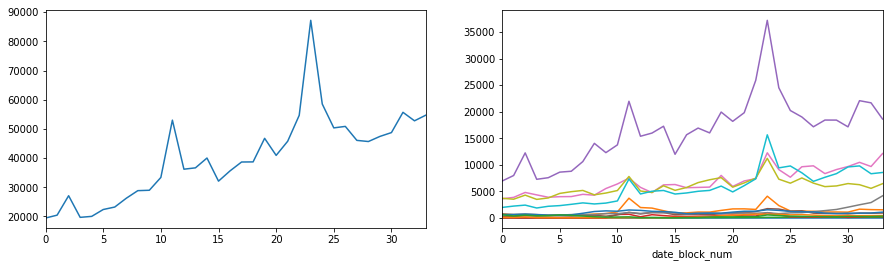

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

train_monthly.groupby(['date_block_num']).sum().reset_index()['item_cnt'].plot(ax=ax[0])
train_cat_monthly = pd.merge(train_monthly, items, on=['item_id'], how='left')
train_cat_monthly.pivot_table(index=['date_block_num'], columns=['item_group'], values='item_cnt', aggfunc=np.sum, fill_value=0).plot(ax=ax[1], legend=False)

## Item prices

In [0]:
# Price mean by month,shop,item
train_price = train_grp['item_price'].mean().reset_index()
price = train_price[~train_price['item_price'].isnull()]

# last price by shop,item
last_price = price.drop_duplicates(subset=['shop_id', 'item_id'], keep='last').drop(['date_block_num'], axis=1)

# null price by shop,item
'''
mean_price = price.groupby(['item_id'])['item_price'].mean().reset_index()
result_price = pd.merge(test, mean_price, on=['item_id'], how='left').drop('ID', axis=1)
pred_price_set = result_price[result_price['item_price'].isnull()]
'''
uitem = price['item_id'].unique()
pred_price_set = test[~test['item_id'].isin(uitem)].drop('ID', axis=1)

In [28]:
if len(pred_price_set) > 0:
    train_price_set = pd.merge(price, items, on=['item_id'], how='inner')
    pred_price_set = pd.merge(pred_price_set, items, on=['item_id'], how='inner').drop(['item_name'], axis=1)
    reg = ensemble.ExtraTreesRegressor(n_estimators=25, n_jobs=-1, max_depth=15, random_state=42)
    reg.fit(train_price_set[pred_price_set.columns], train_price_set['item_price'])
    pred_price_set['item_price'] = reg.predict(pred_price_set)

test_price = pd.concat([last_price, pred_price_set], join='inner')
test_price.head()

,shop_id,item_id,item_price
209,2,1204,299.0
211,2,1224,399.0
219,2,1247,299.0
826,2,3656,299.0
1064,2,4531,279.0


## Discount rate

In [29]:
price_max = price.groupby(['item_id']).max()['item_price'].reset_index()
price_max.rename(columns={'item_price':'item_max_price'}, inplace=True)
price_max.head()

,item_id,item_max_price
0,30,399.0
1,31,699.0
2,32,349.0
3,33,499.0
4,38,2399.0


In [30]:
train_price_a = pd.merge(price, price_max, on=['item_id'], how='left')
train_price_a['discount_rate'] = 1 - (train_price_a['item_price'] / train_price_a['item_max_price'])
train_price_a.drop('item_max_price', axis=1, inplace=True)
train_price_a.head()

,date_block_num,shop_id,item_id,item_price,discount_rate
0,0,2,33,499.0,0.000000
1,0,2,482,3300.0,0.000000
2,0,2,491,600.0,0.000000
3,0,2,839,3300.0,0.000000
4,0,2,1007,449.0,0.625521


In [31]:
test_price_a = pd.merge(test_price, price_max, on=['item_id'], how='left')
test_price_a.loc[test_price_a['item_max_price'].isnull(), 'item_max_price'] = test_price_a['item_price']
test_price_a['discount_rate'] = 1 - (test_price_a['item_price'] / test_price_a['item_max_price'])
test_price_a.drop('item_max_price', axis=1, inplace=True)
test_price_a.head()

,shop_id,item_id,item_price,discount_rate
0,2,1204,299.0,0.000000
1,2,1224,399.0,0.111359
2,2,1247,299.0,0.000000
3,2,3656,299.0,0.143266
4,2,4531,279.0,0.066890


## Data preparation

In [0]:
def mergeFeature(source): 
  d = source
  d = pd.merge(d, items, on=['item_id'], how='left').drop('item_group', axis=1)
  d = pd.merge(d, item_cats, on=['item_category_id'], how='left')
  d = pd.merge(d, shops, on=['shop_id'], how='left')

  d = pd.merge(d, train_shop, on=['shop_id','item_id'], how='left')
  d = pd.merge(d, train_shop_cat, on=['shop_id','item_group'], how='left')
  d = pd.merge(d, train_prev, on=['date_block_num','shop_id','item_id'], how='left')
  d = pd.merge(d, train_cat_prev, on=['date_block_num','shop_id','item_group'], how='left')
  d = pd.merge(d, train_ema_prev, on=['date_block_num','shop_id','item_id'], how='left')
  
  d['month'] = d['date_block_num'] % 12
  days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
  d['days'] = d['month'].map(days).astype(np.int8)
  
  d.drop(['shop_id','shop_name','item_id','item_name','item_category_id','item_category_name','item_group'], axis=1, inplace=True)
  d.fillna(0.0, inplace=True)
  return d

In [41]:
train_set = train_monthly[train_monthly['date_block_num'] >= 12]

train_set = pd.merge(train_set, train_price_a, on=['date_block_num','shop_id','item_id'], how='left')
train_set = mergeFeature(train_set)

train_set = train_set.join(pd.DataFrame(train_set.pop('item_order'))) # move to last column

X_train = train_set.drop(['item_cnt'], axis=1)
#Y_train = train_set['item_cnt']
Y_train = train_set['item_cnt'].clip(0.,20.)
X_train.head()

,date_block_num,item_price,discount_rate,city,cnt_mean_shop,cnt_med_shop,cnt_std_shop,order_mean_shop,cnt_mean_shop_cat,cnt_prev,...,cnt_prev12,order_prev12,cnt_prev_cat,cnt_ema_s_prev,cnt_ema_l_prev,cnt_macd_prev,cnt_sig_prev,month,days,item_order
0,12,0.0,0.000000,0,0.117647,0.0,0.327035,1.000000,0.038727,0.0,...,0.0,1.0,0.039588,0.104790,0.138890,-0.034100,-0.034100,0,31,1
1,12,0.0,0.000000,0,0.235294,0.0,0.740959,1.088235,0.038727,0.0,...,0.0,1.0,0.039588,0.220062,0.355486,-0.135425,-0.090392,0,31,1
2,12,119.0,0.659026,0,0.323529,0.0,0.638207,1.088235,0.038727,0.0,...,0.0,1.0,0.039588,0.000000,0.000000,0.000000,-0.053346,0,31,1
3,12,199.0,0.601202,0,0.323529,0.0,0.534880,1.029412,0.038727,1.0,...,1.0,1.0,0.039588,0.506989,0.403090,0.103899,-0.000079,0,31,1
4,12,0.0,0.000000,0,0.000000,0.0,0.000000,1.000000,0.038727,0.0,...,0.0,1.0,0.039588,0.000000,0.000000,0.000000,-0.000055,0,31,1


In [0]:
test_set = test.copy()
test_set['date_block_num'] = 34

test_set = pd.merge(test_set, test_price_a, on=['shop_id','item_id'], how='left')
test_set = mergeFeature(test_set)

test_set['item_order'] = test_set['order_prev']
test_set.loc[test_set['item_order'] == 0, 'item_order'] = 1

X_test = test_set.drop(['ID'], axis=1)
X_test.head()

assert(X_train.columns.isin(X_test.columns).all())

In [35]:
X_train.shape

(4712400, 23)

In [36]:
X_test.shape

(214200, 23)

# Here training data is too large & if we train on such huge sample, 
- Need good coputing system
- Time taking

So we train our model over a sample taken from the given data of 10,0000, rows.

## Predict

-  **Model training**

In [37]:
from sklearn import linear_model, preprocessing
from sklearn.model_selection import KFold
import xgboost as xgb
import lightgbm as lgb

params={'learning_rate': 0.05,
        'objective':'rmse',
        'metric':'rmse',
        'num_leaves': 31,
        'verbose': 1,
        'random_state':42,
        'bagging_fraction': 0.7,
        'feature_fraction': 0.7
       }

folds = KFold(n_splits=5, random_state=42)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

for fold_, (trn_, val_) in enumerate(folds.split(X_train[:1000000], Y_train[:1000000])):
    trn_x, trn_y = X_train.iloc[trn_], Y_train[trn_]
    val_x, val_y = X_train.iloc[val_], Y_train[val_]

#     reg = xgb.XGBRegressor(n_estimators=25, max_depth=12, learning_rate=0.1, subsample=1, colsample_bytree=0.9, random_state=42, eval_metric='rmse')
#     reg.fit(trn_x, trn_y)
    reg = lgb.LGBMRegressor(**params, n_estimators=5000)
    reg.fit(trn_x, trn_y, eval_set=[(val_x, val_y)], eval_metric='rmse', early_stopping_rounds=100, verbose=500)
    oof_preds[val_] = reg.predict(val_x)
    sub_preds += reg.predict(X_test) / folds.n_splits

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[242]	valid_0's rmse: 0.177714
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.230749
[1000]	valid_0's rmse: 0.228456
Early stopping, best iteration is:
[1230]	valid_0's rmse: 0.228063
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.173185
Early stopping, best iteration is:
[693]	valid_0's rmse: 0.172186
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.146518
[1000]	valid_0's rmse: 0.145069
[1500]	valid_0's rmse: 0.144549
Early stopping, best iteration is:
[1403]	valid_0's rmse: 0.144522
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's rmse: 0.228536
[1000]	valid_0's rmse: 0.22379
Early stopping, best iteration is:
[1347]	valid_0's rmse: 0.221857


In [0]:
pred_cnt = sub_preds

- **evaluation**

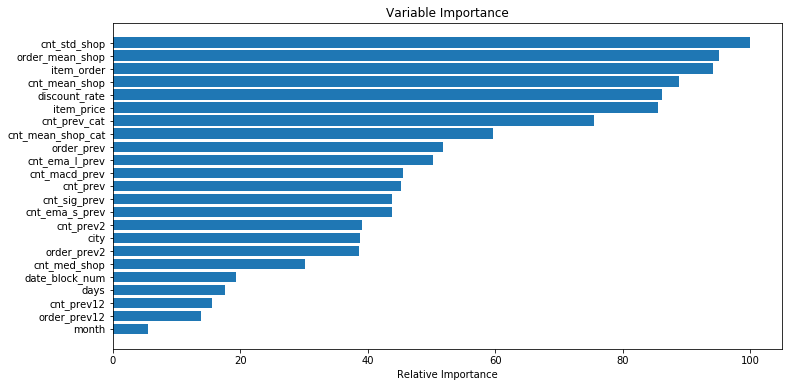

In [39]:
# Plot feature importance
feature_importance = reg.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Submit

In [0]:
result = pd.DataFrame({
    "ID": test["ID"],
    "item_cnt_month": pred_cnt.clip(0. ,20.)
})
result.to_csv("submission.csv", index=False)

In [42]:
print(len(pred_cnt[pred_cnt > 20]))
result.head(10)

10


,ID,item_cnt_month
0,0,1.006279
1,1,0.989354
2,2,1.001461
3,3,1.008909
4,4,0.992575
5,5,0.981336
6,6,2.007201
7,7,1.061459
8,8,0.968492
9,9,0.000000
